# Module 14: Logistic Regression

Sections:
- 0: Setup
- 1: Introduction to Logistic Regression (toy example)
- 2: Sigmoid Function and Classification Intuition
- 3: Logistic Regression on a Real Dataset
- 4: Evaluation Metrics and Threshold Effects
- 5: L2 Regularization
- 6: Conclusion and Next Steps

## Section 0 – Setup

In this section we will:
- Import required libraries
- Set a random seed for reproducibility
- A short outline for students to follow the flow.

In [57]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import StandardScaler

## Section 1 – Introduction to Logistic Regression (toy example)

Goal:
- A very simple feel of what logistic regression does before we dive into math.

We will create a tiny toy dataset:
- Feature: `hours_studied`
- Target: `pass_exam` (0 or 1)

Then we will:
- Fit a logistic regression model in sklearn
- Predict pass or fail for a few sample students
- Plot the points and the model prediction curve.

Outcome:
- Linear regression predicts a continuous number
- Logistic regression predicts a probability between 0 and 1.


In [58]:
# Create a simple toy dataset
hours_studied = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]).reshape(-1, 1)
pass_exam = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1])

toy_df = pd.DataFrame({
    "hours_studied": hours_studied.flatten(),
    "pass_exam": pass_exam
})

toy_df

,hours_studied,pass_exam
0,1,0
1,2,0
2,3,0
3,4,0
4,5,1
5,6,1
6,7,1
7,8,1
8,9,1


In [49]:
# Fit logistic regression on the toy dataset
toy_model = LogisticRegression()
toy_model.fit(hours_studied, pass_exam)

print("Intercept (b):", toy_model.intercept_)
print("Coefficient (w):", toy_model.coef_)

Intercept (b): [-5.29559243]
Coefficient (w): [[1.17808562]]


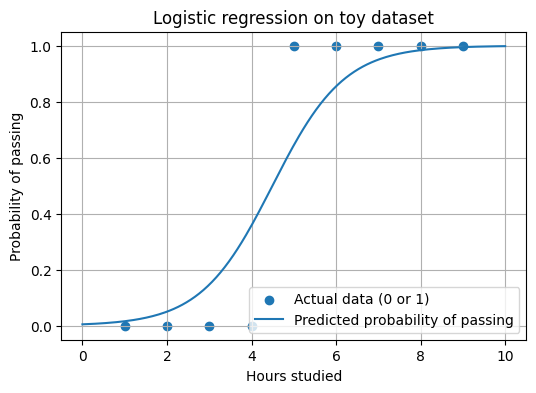

In [50]:
# Predict probabilities for a range of study hours
hours_grid = np.linspace(0, 10, 200).reshape(-1, 1)
pass_prob = toy_model.predict_proba(hours_grid)[:, 1]

# Plot data points and probability curve
plt.figure(figsize=(6, 4))
plt.scatter(hours_studied, pass_exam, label="Actual data (0 or 1)")
plt.plot(hours_grid, pass_prob, label="Predicted probability of passing")
plt.xlabel("Hours studied")
plt.ylabel("Probability of passing")
plt.title("Logistic regression on toy dataset")
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# Predict for a few example students
example_hours = np.array([[2], [4], [6], [8]])
example_probs = toy_model.predict_proba(example_hours)[:, 1]
example_pred = toy_model.predict(example_hours)

results_df = pd.DataFrame({
    "hours_Studied": example_hours.flatten(),
    "Predicted_probability_pass": np.round(example_probs, 4),
    "Predicted_class": example_pred
})

results_df

,hours_Studied,Predicted_probability_pass,Predicted_class
0,2,0.0502,0
1,4,0.3582,0
2,6,0.8548,1
3,8,0.9842,1


**Notes:**

- Ekhane model bole je beshi porle pass korar chance barbe.  
- Logistic regression is giving a probability, not a raw pass or fail. The predicted class comes after applying a threshold like 0.5.


## Section 2 – Sigmoid Function and Classification Intuition

Here we:
- Define the sigmoid function in code
- See how it maps any real number to a probability between 0 and 1
- Check some example values
- Visualize the sigmoid curve
- Play with a simple decision threshold.


In [52]:
#Sigmoid Function
def sigmoid(z):
  return 1/(1+ np.exp(-z))

# Check some values
z_values = np.array([-5, -2, -1, 0, 1, 2, 5], dtype=float)
sig_values = sigmoid(z_values)

sig_df = pd.DataFrame({
    "z": z_values,
    "sigmoid(z)": np.round(sig_values, 4)
})

sig_df

,z,sigmoid(z)
0,-5.0,0.0067
1,-2.0,0.1192
2,-1.0,0.2689
3,0.0,0.5000
4,1.0,0.7311
5,2.0,0.8808
6,5.0,0.9933


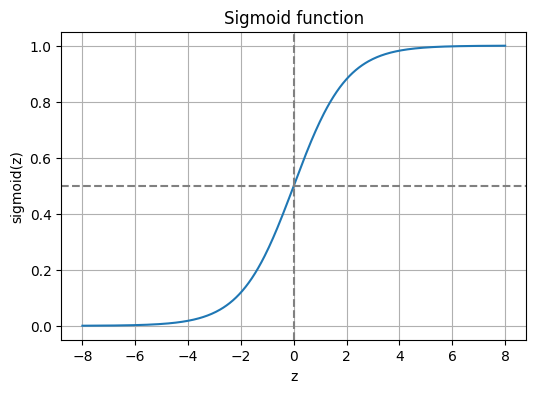

In [53]:
# Plot the sigmoid curve
z_grid = np.linspace(-8, 8, 400)
sig_grid = sigmoid(z_grid)

plt.figure(figsize=(6, 4))
plt.plot(z_grid, sig_grid)
plt.xlabel("z")
plt.ylabel("sigmoid(z)")
plt.title("Sigmoid function")
plt.grid(True)
plt.axhline(0.5, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.show()

In [54]:
# Simple threshold demonstration
probabilities = np.array([0.1, 0.3, 0.49, 0.5, 0.7, 0.9])
threshold = 0.25
pred_class = (probabilities >= threshold).astype(int)

thresh_df = pd.DataFrame({
    "probability": probabilities,
    "class_at_threshold_0.5": pred_class
})
thresh_df

,probability,class_at_threshold_0.5
0,0.10,0
1,0.30,1
2,0.49,1
3,0.50,1
4,0.70,1
5,0.90,1


**Notes:**

- Sigmoid is a smooth S shaped function that takes any score and turns it into a probability.
- At `z = 0`, probability is 0.5.
- Values far below 0 map close to 0, and far above 0 map close to 1.
- The model first gives a score `z`, then passes it through sigmoid to get probability, which is how logistic regression works.


## Section 3 – Logistic Regression on a Real Dataset

Now we move to a real dataset. To keep it simple and local inside the notebook, we will use the `breast_cancer` dataset from `sklearn`.

Goal:
- Load data
- Do a quick EDA
- Train logistic regression
- Evaluate using basic metrics
- Inspect confusion matrix and classification report.


In [55]:
#Load data
data = load_breast_cancer()
X_full = data.data
y_full = data.target

print("Feature matrix shape:", X_full.shape)
print("Target shape:", y_full.shape)
print("Classes:", data.target_names)

Feature matrix shape: (569, 30)
Target shape: (569,)
Classes: ['malignant' 'benign']


**Breast Cancer Dataset (sklearn) Feature Explanations:**

* mean radius

Average radius of the cell nucleus. Larger radius often indicates abnormal cell growth.

* mean texture

Variation in pixel brightness inside the nucleus. Higher variation may indicate structural irregularity.

* mean perimeter

Length of the nucleus boundary. Larger perimeter suggests irregular or enlarged cells.

* mean area

Area of the cell nucleus. Malignant cells commonly have larger areas.

* mean smoothness

How smooth the nucleus edges are. Low smoothness suggests rough, uneven edges.

* mean compactness

Tightness of the cell shape. Higher compactness can signify abnormal structure.

* mean concavity

Depth of inward curves on the nucleus boundary. Cancerous cells tend to have deeper concavities.

* mean concave points

Number of inward-pointing segments along the boundary. More concave points often indicate malignancy.

* mean symmetry

Symmetry of the nucleus. Cancerous cells are usually less symmetrical.

* mean fractal dimension

Complexity of the nucleus boundary. Higher values mean more irregular shapes.

**Standard Error (Variation) Features**

* radius error

How much the radius varies. Higher variation signals inconsistent cell shapes.

* texture error

Variation in texture. High variation may indicate abnormal tissue patterns.

* perimeter error

Variation in perimeter length.

* area error

Variation in nucleus area.

* smoothness error

Variation in smoothness values.

* compactness error

Variation in compactness.

* concavity error

Variation in concavity levels.

* concave points error

Variation in number of concave points.

* symmetry error

Variation in symmetry measurements.

* fractal dimension error

Variation in complexity of the nucleus boundary.

**Worst (Largest Observed) Features**

* worst radius

Largest radius recorded. Often a strong cancer indicator.

* worst texture

Highest texture variation.

* worst perimeter

Largest perimeter value.

* worst area

Largest cell area measured.

* worst smoothness

Worst (most irregular) smoothness value.

* worst compactness

Largest compactness observed.

* worst concavity

Deepest concavity measured.

* worst concave points

Highest number of concave boundary points.

* worst symmetry

Worst symmetry measurement.

* worst fractal dimension

Most irregular and complex boundary shape.

In [60]:
# Create a DataFrame for easier exploration
feature_names = data.feature_names
df = pd.DataFrame(X_full, columns=feature_names)
df["target"] = y_full

df.head(10)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0


In [62]:
#Explore the data with describe()
df.describe().T.head(15)

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.37000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.84000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.24000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.10000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.09587,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.09263,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.06154,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.03350,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.17920,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.06154,0.066120,0.09744


In [63]:
#Class count
df["target"].value_counts()

,count
target,
1,357
0,212


In [64]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
# Train logistic regression on the scaled data
clf = LogisticRegression(max_iter=100)
clf.fit(X_train_scaled, y_train)

y_test_pred = clf.predict(X_test_scaled)
y_test_proba = clf.predict_proba(X_test_scaled)[:, 1]
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))

Test Accuracy:  0.9824561403508771


In [67]:
# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix:\n",cm)

Confusion matrix:
 [[41  1]
 [ 1 71]]


In [68]:
print("\nClassification repot:\n", classification_report(y_test, y_test_pred))


Classification repot:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



**What a classification report is:**

A classification report is a quick scorecard that tells you how well your classification model performed.
It gives you four important numbers for each class:

1. **Precision**

Out of everything the model predicted as this class, how many were actually correct.
Think of it like:

*When the model says “yes,” how often is it not lying?*

2. **Recall**

Out of all the real items in this class, how many did the model successfully find.
Think of it like:

*How many real positives did the model manage to catch?*

3. **F1 Score**

The balanced score between precision and recall.
If precision is good but recall is horrible, F1 exposes it.

4. **Support**

How many actual samples you had in each class.
This helps you check if the dataset is imbalanced.

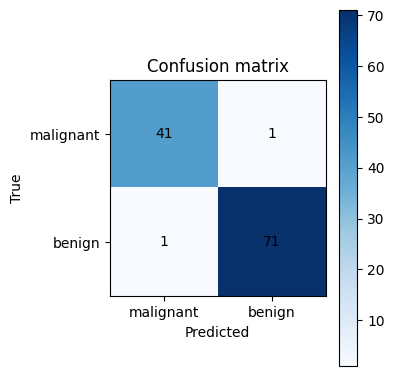

In [69]:
# Visual confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion matrix")
plt.colorbar()
tick_labels = data.target_names
plt.xticks([0, 1], tick_labels)
plt.yticks([0, 1], tick_labels)
plt.xlabel("Predicted")
plt.ylabel("True")

# Add numbers to each cell
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.tight_layout()
plt.show()

**Notes:**

- Even with a simple model like logistic regression, performance can be quite strong when the relationship is roughly linear in the feature space.
- Each cell in the confusion matrix means: true positive, true negative, false positive, false negative.


## Section 4 – Evaluation Metrics and Threshold Effects

We now:
- Compute accuracy, precision, recall, F1
- Experiment with different classification thresholds on the predicted probabilities
- See how precision and recall trade off when we move the threshold.


In [70]:
# Basic metrics at default threshold 0.5
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 score:", f1)

In [71]:
# Try different thresholds and see how precision and recall change
thresholds = np.linspace(0.1, 0.9, 9)
rows = []

for thr in thresholds:
    y_thr_pred = (y_test_proba >= thr).astype(int)
    acc_thr = accuracy_score(y_test, y_thr_pred)
    prec_thr = precision_score(y_test, y_thr_pred)
    rec_thr = recall_score(y_test, y_thr_pred)
    f1_thr = f1_score(y_test, y_thr_pred)
    rows.append([thr, acc_thr, prec_thr, rec_thr, f1_thr])

thr_df = pd.DataFrame(rows, columns=["threshold", "accuracy", "precision", "recall", "f1"])
thr_df

In [ ]:
# Plot precision and recall vs threshold
# plt.figure(figsize=(6, 4))
# plt.plot(thr_df["threshold"], thr_df["precision"], marker="o", label="Precision")
# plt.plot(thr_df["threshold"], thr_df["recall"], marker="o", label="Recall")
# plt.xlabel("Threshold")
# plt.ylabel("Score")
# plt.title("Precision and Recall vs Threshold")
# plt.grid(True)
# plt.legend()
# plt.show()

**Notes:**

- If you want fewer false negatives (for example, missing a serious disease), should you increase or decrease the threshold.
- Explain that decreasing the threshold usually increases recall but may reduce precision.


## Section 5 – L2 Regularization

Regularization helps control model complexity by shrinking coefficients.

In sklearn's `LogisticRegression`:
- `penalty="l2"` is the default
- `C` controls strength of regularization. Smaller `C` means stronger regularization.

Here we:
- Train two models with different `C` values
- Compare their coefficients and performance.


In [ ]:
# Two models with different regularization strengths


In [ ]:
# Compare coefficient magnitudes


Left column: model is “overconfident,” throwing big weights around.

Right column: model is “chill,” using smaller, more balanced weights because regularization is keeping it in check.

In [ ]:
# Plot absolute values for the first 10 coefficients
n_plot = 10
indices = np.arange(n_plot)

plt.figure(figsize=(8, 4))
plt.bar(indices - 0.15, np.abs(coef_weak[:n_plot]), width=0.3, label="C=1000")
plt.bar(indices + 0.15, np.abs(coef_strong[:n_plot]), width=0.3, label="C=0.01")
plt.xticks(indices, feature_names[:n_plot], rotation=45, ha="right")
plt.ylabel("Absolute coefficient value")
plt.title("Effect of L2 regularization on coefficients (first 10 features)")
plt.legend()
plt.tight_layout()
plt.show()

**Notes:**

- With stronger regularization (smaller C), many coefficients become smaller in magnitude.
- This often leads to better generalization by avoiding extremely large weights that overfit noise.


## Section 6 – Conclusion and Next Steps

In this module we covered:

- Why logistic regression is used for classification instead of linear regression
- How the sigmoid function converts scores to probabilities
- The idea of log odds and a linear decision boundary
- Training logistic regression with a suitable cost function (binary cross entropy)
- Implementing logistic regression on a real dataset with sklearn
- Evaluating models using accuracy, precision, recall, F1, and confusion matrix
- Improving generalization with L2 regularization by shrinking coefficients.

**What you should be able to do now:**

- Explain logistic regression
- Implement logistic regression in sklearn on a tabular dataset
- Interpret confusion matrices and basic classification metrics
- Experiment with thresholds and understand the trade off between precision and recall
- Understand the role of L2 regularization and the effect of the C parameter.

**Next steps:**

- Move to other classification models like decision trees and random forests
- Explore multi class classification with softmax based logistic regression
